In [219]:
from medigraph.data.abide import DEFAULT_ABIDE_LOCATION, AbideData
import numpy as np
from nilearn import plotting
from medigraph.model.gcn import GCN, DenseNN
import torch
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [178]:
dat = AbideData()

### Check connectivy matrix for a single patient
- 111x111 matrices
- We'll retrieve the $6216=\frac{111*(111+1)}{2}$ raw coefficients from the upper triangular matrix

input feature vector shape: (6216,)


/home/bneveu/.local/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:327: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/home/bneveu/.local/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:331: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


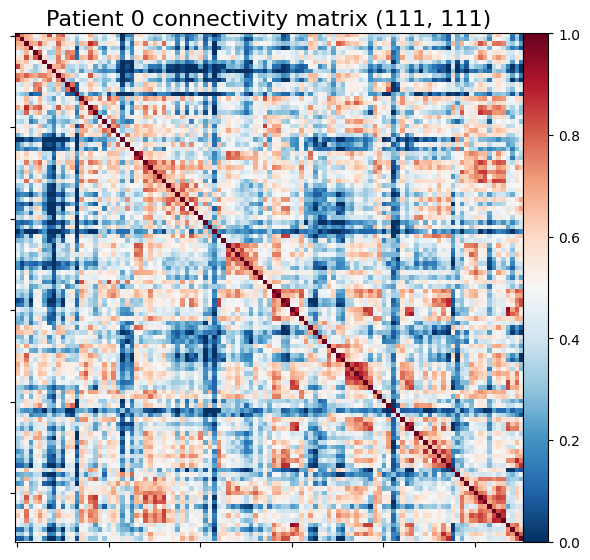

In [179]:
# Get the connectivity matrix for the first subject
idx = 0
mat = dat.get_connectivity_matrix(idx)
plotting.plot_matrix(
    mat,
    figure=(6, 6),
    vmax=1,
    vmin=0,
    title=f"Patient {idx} connectivity matrix {mat.shape}"
)
feature_vector_input = dat.get_connectivity_features(idx)
print(f"input feature vector shape: {feature_vector_input.shape}")


# Train classifier
### Build adjacency, features matrix and classification labels

In [181]:
# % Build adjacency matrix and input feature vectors
adj_np = dat.get_graph_adjacency() # [V, V]
inp_np = dat.get_input_feature_map() # [V, F]
labels_np = dat.get_labels()
adj_np.shape, inp_np.shape, labels_np.shape

Metadata mask: 100%|██████████| 871/871 [01:24<00:00, 10.35it/s] 


((871, 871), (871, 6216), (871,))

In [253]:
# % Load data to GPU
labels_np = dat.get_labels()
adj = torch.tensor(adj_np, dtype=torch.float32).to(device)
inp = torch.tensor(inp_np, dtype=torch.float32).to(device)
lab = torch.tensor(labels_np, dtype=torch.float32).to(device) # for binary classification
inp.shape, adj.shape, lab.shape

(torch.Size([871, 6216]), torch.Size([871, 871]), torch.Size([871]))

In [281]:
# % Train 
N_EPOCHS = 1000

criterion = torch.nn.BCEWithLogitsLoss()
training_losses_dict = {}
training_accuracy_dict = {}
for model_name in ["GCN", "Dense"]:
    if model_name == "GCN":
        model = GCN(inp.shape[1], adj, hdim=64)
    else:
        model = DenseNN(inp.shape[1], hdim=64)
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=1.E-3, weight_decay=0.1) #
    training_losses = []
    training_accuracies = []
    for ep in tqdm(range(N_EPOCHS)):
        model.train()
        optim.zero_grad()
        logit = model(inp)
        loss = criterion(logit, lab)
        loss.backward()
        optim.step()
        with torch.no_grad(): 
            predicted_prob = torch.sigmoid(logit).squeeze()  # Apply sigmoid and remove extra dimensions if any
            predicted = (predicted_prob >= 0.5).long()  # Convert probabilities to 0 or 1
            correct = (predicted == lab).sum().item()
            total = lab.shape[0]
            accuracy = correct / total
            training_accuracies.append(accuracy)
        if ep % 100 == 0:
            print(f"Epoch {ep} loss: {loss.item():10f} - accuracy: {accuracy:.2%}") 
        training_losses.append(loss.detach().cpu())
    training_losses_dict[model_name] = training_losses
    training_accuracy_dict[model_name] = training_accuracies

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 loss:   0.700073 - accuracy: 46.27%
Epoch 100 loss:   0.691304 - accuracy: 53.73%
Epoch 200 loss:   0.690739 - accuracy: 53.73%
Epoch 300 loss:   0.690592 - accuracy: 53.73%
Epoch 400 loss:   0.690588 - accuracy: 53.73%
Epoch 500 loss:   0.690588 - accuracy: 53.73%
Epoch 600 loss:   0.690588 - accuracy: 53.73%
Epoch 700 loss:   0.690588 - accuracy: 53.73%
Epoch 800 loss:   0.690588 - accuracy: 53.73%
Epoch 900 loss:   0.690588 - accuracy: 53.73%


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 loss:   0.692290 - accuracy: 53.73%
Epoch 100 loss:   0.566223 - accuracy: 69.80%
Epoch 200 loss:   0.470135 - accuracy: 84.27%
Epoch 300 loss:   0.430716 - accuracy: 84.85%
Epoch 400 loss:   0.473058 - accuracy: 77.04%
Epoch 500 loss:   0.358908 - accuracy: 91.62%
Epoch 600 loss:   0.348231 - accuracy: 90.01%
Epoch 700 loss:   0.331633 - accuracy: 92.65%
Epoch 800 loss:   0.331296 - accuracy: 90.59%
Epoch 900 loss:   0.321233 - accuracy: 94.26%


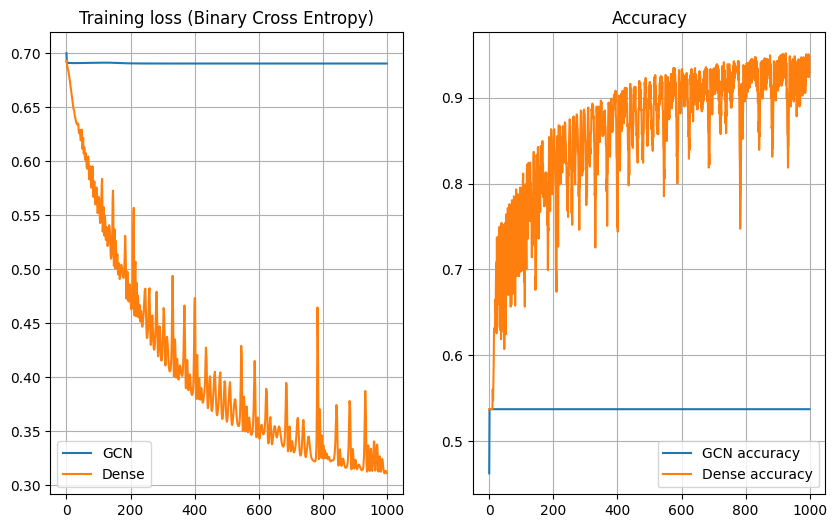

In [287]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for model_name, training_losses in training_losses_dict.items():
    axs[0].plot(training_losses, label=model_name)
    axs[1].plot(training_accuracy_dict[model_name], label=f"{model_name} accuracy")
for ax in axs:
    ax.legend()
    ax.grid()
axs[0].set_title("Training loss (Binary Cross Entropy)")
axs[1].set_title("Accuracy")

plt.show()